In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix
from sklearn import model_selection  
import lightgbm as lgb
import time
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

In [2]:
# Transaction CSVs
train_identity= pd.read_csv("../input/ieee-fraud-detection/train_identity.csv")
train_transaction = pd.read_csv("../input/ieee-fraud-detection/train_transaction.csv")
test_transaction = pd.read_csv("../input/ieee-fraud-detection/test_transaction.csv")
test_identity= pd.read_csv("../input/ieee-fraud-detection/test_identity.csv")

In [3]:
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
#Keep every row in the left dataframe.
test  = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [4]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [5]:
print(train.shape)
print(test.shape)

(590540, 434)
(506691, 433)


In [6]:
# This Step is done to reduce memory by conversion
# convert it to the low memory to fit the RAM
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            #Downsizing 
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    #iinfo-Machine limits for integer datatype
                    df[col] = df[col].astype(np.int8)
                    #Casting pandas object to a certain type-to int8,int16,int32 &int64 depending on size
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
# Using  above function to reduce memory usage for Train test df
train_df=reduce_mem_usage(train)
test_df=reduce_mem_usage(test)

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)


In [7]:
print("Train shape: ", train.shape)
print("Test shape:", test.shape)

Train shape:  (590540, 434)
Test shape: (506691, 433)


In [8]:
# Explore Categorical features
print('Training set:')
for col_name in train_df.columns:
    if train_df[col_name].dtypes == 'object' :
        unique_cat = len(train_df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

print("****************")
    
print('Test set:')
for col_name in test_df.columns:
    if test_df[col_name].dtypes == 'object' :
        unique_cat = len(test_df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

Training set:
Feature 'ProductCD' has 5 categories
Feature 'card4' has 5 categories
Feature 'card6' has 5 categories
Feature 'P_emaildomain' has 60 categories
Feature 'R_emaildomain' has 61 categories
Feature 'M1' has 3 categories
Feature 'M2' has 3 categories
Feature 'M3' has 3 categories
Feature 'M4' has 4 categories
Feature 'M5' has 3 categories
Feature 'M6' has 3 categories
Feature 'M7' has 3 categories
Feature 'M8' has 3 categories
Feature 'M9' has 3 categories
Feature 'id_12' has 3 categories
Feature 'id_15' has 4 categories
Feature 'id_16' has 3 categories
Feature 'id_23' has 4 categories
Feature 'id_27' has 3 categories
Feature 'id_28' has 3 categories
Feature 'id_29' has 3 categories
Feature 'id_30' has 76 categories
Feature 'id_31' has 131 categories
Feature 'id_33' has 261 categories
Feature 'id_34' has 5 categories
Feature 'id_35' has 3 categories
Feature 'id_36' has 3 categories
Feature 'id_37' has 3 categories
Feature 'id_38' has 3 categories
Feature 'DeviceType' has 3 ca

In [9]:
cat_cols = [col for col in train_df.columns if train_df[col].dtype in ['object']]
cat_cols

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_12',
 'id_15',
 'id_16',
 'id_23',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo']

In [10]:
v_feat = train_df.columns[55:394]
v_feat

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=339)

In [11]:
v_test_feat=test_df.columns[54:393]

In [12]:
v_test_feat

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=339)

In [13]:
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA

In [14]:
#Replacing NULL values
for col in v_feat:
    train_df[col].fillna((train_df[col].min() - 2), inplace=True)
    train_df[col] = (minmax_scale(train_df[col], feature_range=(0,1)))

In [15]:
pca = PCA(n_components=35,random_state=5)
principalComponents = pca.fit_transform(train_df[v_feat])

In [16]:
principalComponents

array([[-0.15733006,  0.91926589, -0.84373295, ...,  0.06969809,
         0.01908068,  0.04523338],
       [-0.08643819, -0.8001318 , -0.15224688, ...,  0.00823132,
         0.00258103, -0.00395146],
       [-0.80084342,  0.31691703,  0.27315972, ..., -0.00213845,
        -0.00311002,  0.00740497],
       ...,
       [-0.93234751,  0.35644447,  0.29727175, ...,  0.00258769,
        -0.00140363,  0.00789809],
       [-0.88923966,  0.32724483,  0.28907554, ..., -0.00187598,
        -0.01822701,  0.05123707],
       [-1.06408158,  0.33512523,  0.34209797, ...,  0.01541071,
        -0.02576041,  0.01007628]])

In [17]:
principalDf = pd.DataFrame(principalComponents)

In [18]:
principalDf.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,-0.157330,0.919266,-0.843733,0.307989,-0.089398,0.003048,-0.020015,-0.187605,0.038161,0.002644,...,-0.007287,0.004137,-0.043361,0.008989,-0.004525,-0.049473,-0.021763,0.069698,0.019081,0.045233
1,-0.086438,-0.800132,-0.152247,-0.363368,-0.101824,-0.002264,0.032351,-0.068962,0.040102,-0.180065,...,0.003692,0.001593,0.001673,-0.003802,-0.003731,-0.024195,-0.002311,0.008231,0.002581,-0.003951
2,-0.800843,0.316917,0.273160,-0.026327,0.043152,-0.008078,-0.039239,-0.217008,0.017641,0.033532,...,0.001721,0.003934,0.002866,-0.019697,-0.002890,-0.002079,0.005757,-0.002138,-0.003110,0.007405
3,-0.237308,-0.811481,-0.123694,-0.423546,-0.067284,0.025050,0.110473,-0.253713,0.004768,0.170437,...,0.025665,0.003899,0.003744,0.026352,-0.041906,0.009657,0.006851,0.008940,0.011320,0.006865
4,2.903822,0.380081,0.480550,-0.009628,-0.171648,1.170917,-0.178348,0.004477,0.043780,-0.001622,...,0.014021,0.013005,0.002317,0.014822,-0.000498,0.001924,0.006876,-0.008638,0.015000,0.105150


In [19]:
train_df.drop(v_feat,axis=1,inplace=True)

In [20]:
train_df.shape

(590540, 95)

In [21]:
principalDf.rename(columns=lambda x: str('V')+str(x), inplace=True)

In [22]:
principalDf.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34
0,-0.157330,0.919266,-0.843733,0.307989,-0.089398,0.003048,-0.020015,-0.187605,0.038161,0.002644,...,-0.007287,0.004137,-0.043361,0.008989,-0.004525,-0.049473,-0.021763,0.069698,0.019081,0.045233
1,-0.086438,-0.800132,-0.152247,-0.363368,-0.101824,-0.002264,0.032351,-0.068962,0.040102,-0.180065,...,0.003692,0.001593,0.001673,-0.003802,-0.003731,-0.024195,-0.002311,0.008231,0.002581,-0.003951
2,-0.800843,0.316917,0.273160,-0.026327,0.043152,-0.008078,-0.039239,-0.217008,0.017641,0.033532,...,0.001721,0.003934,0.002866,-0.019697,-0.002890,-0.002079,0.005757,-0.002138,-0.003110,0.007405
3,-0.237308,-0.811481,-0.123694,-0.423546,-0.067284,0.025050,0.110473,-0.253713,0.004768,0.170437,...,0.025665,0.003899,0.003744,0.026352,-0.041906,0.009657,0.006851,0.008940,0.011320,0.006865
4,2.903822,0.380081,0.480550,-0.009628,-0.171648,1.170917,-0.178348,0.004477,0.043780,-0.001622,...,0.014021,0.013005,0.002317,0.014822,-0.000498,0.001924,0.006876,-0.008638,0.015000,0.105150


In [23]:
 train_df = pd.concat([train_df, principalDf], axis=1)

In [24]:
train_df.shape

(590540, 130)

In [25]:
#Replacing NULL values for test data
for col in v_test_feat:
    test_df[col].fillna((test_df[col].min() - 2), inplace=True)
    test_df[col] = (minmax_scale(test_df[col], feature_range=(0,1)))

In [26]:
pca = PCA(n_components=35,random_state=5)
pComponents = pca.fit_transform(test_df[v_test_feat])

In [27]:
test_principalDf = pd.DataFrame(pComponents)

In [28]:
test_df.drop(v_test_feat,axis=1,inplace=True)

In [29]:
test_principalDf.rename(columns=lambda x: str('V')+str(x), inplace=True)

In [30]:
 test_df = pd.concat([test_df, test_principalDf], axis=1)

In [31]:
test_df.shape

(506691, 129)

In [32]:
train_df['DeviceInfo'].describe()

count      118666
unique       1786
top       Windows
freq        47722
Name: DeviceInfo, dtype: object

In [33]:
#Frequency Table-CrossTab
data_freq=pd.crosstab(index=train_df['DeviceInfo'], columns="count")    

In [34]:
data_freq=data_freq[data_freq['count']>350]

In [35]:
data_freq.shape

(10, 1)

In [36]:
data_freq

col_0,count
DeviceInfo,
MacOS,12573
SM-G531H Build/LMY48B,410
SM-G610M Build/MMB29K,461
SM-J700M Build/MMB29K,549
Trident/7.0,7440
Windows,47722
iOS Device,19782
rv:11.0,1901
rv:57.0,962


In [37]:
def change_value_Dev_Info(x) :
    if x in ['ALE-L23 Build/HuaweiALE-L23', 'MacOS', 'Trident/7.0' ,'Windows','iOS Device','rv:11.0	','rv:57.0','rv:59.0','SM-G531H Build/LMY48B','SM-G610M Build/MMB29K','SM-J700M Build/MMB29K'] :
        return 0
    else :
        return 1
    
train_df.loc[:,'DeviceInfo'] = train_df['DeviceInfo'].apply(lambda x : change_value_Dev_Info(x))
test_df.loc[:,'DeviceInfo'] = test_df['DeviceInfo'].apply(lambda x : change_value_Dev_Info(x))

In [38]:
print(train_df.shape)
print(test_df.shape)

(590540, 130)
(506691, 129)


In [39]:
def change_value_P_emaildomain(x) :
    if x in ['gmail.com', 'icloud.com', 'mail.com' , 'outlook.es', 'protonmail.com'] :
        return x
    else :
        return 'etc'
    
train_df.loc[:,'P_emaildomain'] = train_df['P_emaildomain'].apply(lambda x : change_value_P_emaildomain(x))
test_df.loc[:,'P_emaildomain'] = test_df['P_emaildomain'].apply(lambda x : change_value_P_emaildomain(x))

In [40]:
def change_value_R_emaildomain(x) :
    if x in ['gmail.com', 'icloud.com', 'mail.com' , 'outlook.es', 'protonmail.com'] :
        return x
    else :
        return 'etc'
    
train_df.loc[:,'R_emaildomain'] = train_df['R_emaildomain'].apply(lambda x : change_value_P_emaildomain(x))
test_df.loc[:,'R_emaildomain'] = test_df['R_emaildomain'].apply(lambda x : change_value_P_emaildomain(x))

In [41]:
data_news=pd.crosstab(index=train_df['DeviceType'], columns="count")    

In [42]:
data_news

col_0,count
DeviceType,
desktop,85165
mobile,55645


In [43]:
def change_value_Dev_Type(x) :
    if x in ['desktop', 'mobile'] :
        return 0
    else :
        return 1
    
train_df.loc[:,'DeviceType'] = train_df['DeviceType'].apply(lambda x : change_value_Dev_Type(x))
test_df.loc[:,'DeviceType'] = test_df['DeviceType'].apply(lambda x : change_value_Dev_Type(x))

In [44]:
#Replacing NULL values in Device Info and Device Type with 0 i.e-Unrecognized Activity
train_df[['DeviceType', 'DeviceInfo']] = train_df[['DeviceType','DeviceInfo']].fillna(value=0)
test_df[['DeviceType', 'DeviceInfo']] = test_df[['DeviceType','DeviceInfo']].fillna(value=0)

In [45]:
m_feat = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

for col in m_feat:
    train_df[col].fillna('None', inplace=True)
    test_df[col].fillna('None',inplace=True)

In [46]:
train_df[m_feat].dtypes

M1    object
M2    object
M3    object
M4    object
M5    object
M6    object
M7    object
M8    object
M9    object
dtype: object

In [47]:
train_df[m_feat].describe()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
count,590540,590540,590540,590540,590540,590540,590540,590540,590540
unique,3,3,3,4,3,3,3,3,3
top,T,T,None,None,None,F,None,None,None
freq,319415,285468,271100,281444,350482,227856,346265,346252,346252


In [48]:
d_feat =['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11','D12', 'D13', 'D14', 'D15']

In [49]:
train_df[d_feat].describe()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
count,589271.0,309743.0,327662.0,421618.0,280699.0,73187.0,38917.0,74926.000000,74926.000000,514518.0,311253.0,64717.0,61952.0,62187.0,501427.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,0.560059,NaN,NaN,inf,inf,inf,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,0.316650,NaN,NaN,inf,inf,inf,NaN
min,0.0,0.0,0.0,-122.0,0.0,-83.0,0.0,0.000000,0.000000,0.0,-53.0,-83.0,0.0,-193.0,-83.0
25%,0.0,26.0,1.0,0.0,1.0,0.0,0.0,0.958496,0.208374,0.0,0.0,0.0,0.0,0.0,0.0
50%,3.0,97.0,8.0,26.0,10.0,0.0,0.0,37.875000,0.666504,15.0,43.0,0.0,0.0,0.0,52.0
75%,122.0,276.0,27.0,253.0,32.0,40.0,17.0,188.000000,0.833496,197.0,274.0,13.0,0.0,2.0,314.0
max,640.0,640.0,819.0,869.0,819.0,873.0,843.0,1708.000000,0.958496,876.0,670.0,648.0,847.0,878.0,879.0


In [50]:
train_df[d_feat].isnull().sum()

D1       1269
D2     280797
D3     262878
D4     168922
D5     309841
D6     517353
D7     551623
D8     515614
D9     515614
D10     76022
D11    279287
D12    525823
D13    528588
D14    528353
D15     89113
dtype: int64

In [51]:
train_df[d_feat].describe()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
count,589271.0,309743.0,327662.0,421618.0,280699.0,73187.0,38917.0,74926.000000,74926.000000,514518.0,311253.0,64717.0,61952.0,62187.0,501427.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,0.560059,NaN,NaN,inf,inf,inf,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,0.316650,NaN,NaN,inf,inf,inf,NaN
min,0.0,0.0,0.0,-122.0,0.0,-83.0,0.0,0.000000,0.000000,0.0,-53.0,-83.0,0.0,-193.0,-83.0
25%,0.0,26.0,1.0,0.0,1.0,0.0,0.0,0.958496,0.208374,0.0,0.0,0.0,0.0,0.0,0.0
50%,3.0,97.0,8.0,26.0,10.0,0.0,0.0,37.875000,0.666504,15.0,43.0,0.0,0.0,0.0,52.0
75%,122.0,276.0,27.0,253.0,32.0,40.0,17.0,188.000000,0.833496,197.0,274.0,13.0,0.0,2.0,314.0
max,640.0,640.0,819.0,869.0,819.0,873.0,843.0,1708.000000,0.958496,876.0,670.0,648.0,847.0,878.0,879.0


In [52]:
for col in d_feat:
    train_df[col] = (minmax_scale(train_df[col], feature_range=(0,1)))
    train_df[col] = train_df[col].fillna(-1)

In [53]:
for col in d_feat:
    test_df[col] = (minmax_scale(test_df[col], feature_range=(0,1)))
    test_df[col] = test_df[col].fillna(-1)

In [54]:
print(train_df.shape)
print(test_df.shape)

(590540, 130)
(506691, 129)


In [55]:
c_feat = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7','C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']

for col in c_feat:
    train_df[col] = train_df[col].fillna((train_df[col].min() - 1))
    train_df[col] = (minmax_scale(train_df[col], feature_range=(0,1)))

In [56]:
for col in c_feat:
    test_df[col] = test_df[col].fillna((test_df[col].min() - 1))
    test_df[col] = (minmax_scale(test_df[col], feature_range=(0,1)))

In [57]:
id_cols=['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',
       'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24',
       'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34','id_35','id_36','id_37','id_38']

In [58]:
for col in id_cols:
     print("Feature '{col_name}' has {unique_cat} ".format(col_name=col, unique_cat=train_df[col].dtype))

Feature 'id_01' has float16 
Feature 'id_02' has float32 
Feature 'id_03' has float16 
Feature 'id_04' has float16 
Feature 'id_05' has float16 
Feature 'id_06' has float16 
Feature 'id_07' has float16 
Feature 'id_08' has float16 
Feature 'id_09' has float16 
Feature 'id_10' has float16 
Feature 'id_11' has float16 
Feature 'id_12' has object 
Feature 'id_13' has float16 
Feature 'id_14' has float16 
Feature 'id_15' has object 
Feature 'id_16' has object 
Feature 'id_17' has float16 
Feature 'id_18' has float16 
Feature 'id_19' has float16 
Feature 'id_20' has float16 
Feature 'id_21' has float16 
Feature 'id_22' has float16 
Feature 'id_23' has object 
Feature 'id_24' has float16 
Feature 'id_25' has float16 
Feature 'id_26' has float16 
Feature 'id_27' has object 
Feature 'id_28' has object 
Feature 'id_29' has object 
Feature 'id_30' has object 
Feature 'id_31' has object 
Feature 'id_32' has float16 
Feature 'id_33' has object 
Feature 'id_34' has object 
Feature 'id_35' has objec

In [59]:
cat_id_cols = [col for col in id_cols if train_df[col].dtype in ['object']]

cat_id_cols

['id_12',
 'id_15',
 'id_16',
 'id_23',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38']

In [60]:
test_cat_id=[col for col in id_cols if test_df[col].dtype in ['object']]
test_cat_id

['id_12',
 'id_15',
 'id_16',
 'id_23',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38']

In [61]:
tr_cat=train_df[cat_id_cols]
tr_cat.isnull().sum()

id_12    446307
id_15    449555
id_16    461200
id_23    585371
id_27    585371
id_28    449562
id_29    449562
id_30    512975
id_31    450258
id_33    517251
id_34    512735
id_35    449555
id_36    449555
id_37    449555
id_38    449555
dtype: int64

In [62]:
train_df.drop(cat_id_cols,axis=1,inplace=True)
test_df.drop(cat_id_cols,axis=1,inplace=True)

In [63]:
id_cols=train_df.columns[55:78]
id_cols

Index(['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',
       'id_09', 'id_10', 'id_11', 'id_13', 'id_14', 'id_17', 'id_18', 'id_19',
       'id_20', 'id_21', 'id_22', 'id_24', 'id_25', 'id_26', 'id_32'],
      dtype='object')

In [64]:
for col in id_cols:
    train_df[col] = (minmax_scale(train_df[col], feature_range=(0,1)))
    train_df[col].fillna(-1, inplace=True)

In [65]:
test_id_cols=test_df.columns[54:77]
test_id_cols

Index(['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',
       'id_09', 'id_10', 'id_11', 'id_13', 'id_14', 'id_17', 'id_18', 'id_19',
       'id_20', 'id_21', 'id_22', 'id_24', 'id_25', 'id_26', 'id_32'],
      dtype='object')

In [66]:
for col in test_id_cols:
    test_df[col] = (minmax_scale(test_df[col], feature_range=(0,1)))
    test_df[col].fillna(-1, inplace=True)

In [67]:
train_df['addr1'].describe()

count    524834.0
mean          NaN
std           NaN
min         100.0
25%         204.0
50%         299.0
75%         330.0
max         540.0
Name: addr1, dtype: float64

In [68]:
train_df['addr1'] = (minmax_scale(train_df['addr1'], feature_range=(0,1)))
train_df['addr1'].fillna((train_df['addr1'].max() - 200), inplace=True)

In [69]:
test_df['addr1'].describe()

count    441082.0
mean          NaN
std           NaN
min         100.0
25%         204.0
50%         299.0
75%         330.0
max         540.0
Name: addr1, dtype: float64

In [70]:
test_df['addr1'] = (minmax_scale(test_df['addr1'], feature_range=(0,1)))
test_df['addr1'].fillna((test_df['addr1'].max() - 200), inplace=True)

In [71]:
train_df['addr2'].describe()

count    524834.0
mean          NaN
std           0.0
min          10.0
25%          87.0
50%          87.0
75%          87.0
max         102.0
Name: addr2, dtype: float64

In [72]:
train_df['addr2'].fillna(87,inplace=True)

In [73]:
test_df['addr2'].describe()

count    441082.0
mean          NaN
std           0.0
min          10.0
25%          87.0
50%          87.0
75%          87.0
max         102.0
Name: addr2, dtype: float64

In [74]:
test_df['addr2'].fillna(87,inplace=True)

In [75]:
print(train_df.shape)
print(test_df.shape)

(590540, 115)
(506691, 114)


In [76]:
card_feat=['card1', 'card2', 'card3', 'card4', 'card5', 'card6']
card_feat

['card1', 'card2', 'card3', 'card4', 'card5', 'card6']

In [77]:
for col in card_feat:
     print("Feature '{col_name}' has {unique_cat} ".format(col_name=col, unique_cat=train_df[col].dtype))

Feature 'card1' has int16 
Feature 'card2' has float16 
Feature 'card3' has float16 
Feature 'card4' has object 
Feature 'card5' has float16 
Feature 'card6' has object 


In [78]:
train_cat_card=[col for col in card_feat if train_df[col].dtype in ['object']]
train_cat_card

['card4', 'card6']

In [79]:
num_card=[col for col in card_feat if train_df[col].dtype not in ['object']]
num_card

['card1', 'card2', 'card3', 'card5']

In [80]:
card_types=pd.crosstab(index=train_df['card4'], columns="count")    

In [81]:
card_types

col_0,count
card4,
american express,8328
discover,6651
mastercard,189217
visa,384767


In [82]:
new_card_types=pd.crosstab(index=train_df['card6'], columns="count")   

In [83]:
new_card_types

col_0,count
card6,
charge card,15
credit,148986
debit,439938
debit or credit,30


In [84]:
for col in train_cat_card:
    train_df[col] = train_df[col].fillna('None')

In [85]:
for col in train_cat_card:
    test_df[col] = test_df[col].fillna('None')

In [86]:
for col in num_card:
    train_df[col] = train_df[col].fillna((train_df[col].min() - 1))
    train_df[col] = (minmax_scale(train_df[col], feature_range=(0,1)))

In [87]:
for col in num_card:
    test_df[col] = test_df[col].fillna((test_df[col].min() - 1))
    test_df[col] = (minmax_scale(test_df[col], feature_range=(0,1)))

In [88]:
# Check missing data - Many Columns have more than 50% NA/Null records
def missing_data(df) :
    count = df.isnull().sum()
    percent = (df.isnull().sum()) / (df.isnull().count()) * 100
    total = pd.concat([count, percent], axis=1, keys = ['Count', 'Percent'])
    types = []
    for col in df.columns :
        dtypes = str(df[col].dtype)
        types.append(dtypes)
    total['dtypes'] = types
    
    return np.transpose(total)

total=missing_data(train_df)
print(total)

        TransactionID isFraud TransactionDT TransactionAmt ProductCD    card1  \
Count               0       0             0              0         0        0   
Percent             0       0             0              0         0        0   
dtypes          int32    int8         int32        float16    object  float64   

           card2    card3   card4    card5  ...      V25      V26      V27  \
Count          0        0       0        0  ...        0        0        0   
Percent        0        0       0        0  ...        0        0        0   
dtypes   float16  float16  object  float16  ...  float64  float64  float64   

             V28      V29      V30      V31      V32      V33      V34  
Count          0        0        0        0        0        0        0  
Percent        0        0        0        0        0        0        0  
dtypes   float64  float64  float64  float64  float64  float64  float64  

[3 rows x 115 columns]


In [89]:
## WE will Drop columns with more 50% Null value.
null_percent = train_df.isnull().sum()/train_df.shape[0]*100

cols_to_drop = np.array(null_percent[null_percent > 50].index)

cols_to_drop


array(['dist1', 'dist2'], dtype=object)

In [90]:
# Drop Columns (cols_to_drop) from train and test
train_df = train_df.drop(cols_to_drop, axis=1)
test_df = test_df.drop(cols_to_drop,axis=1)

In [91]:
train_df.fillna(-999)
test_df.fillna(-999)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34
0,3663549,18403224,31.953125,W,0.540814,0.023926,0.383789,visa,0.919922,debit,...,0.050786,0.000686,0.004549,-0.054497,-0.042375,0.034993,-0.020758,0.020852,-0.034361,0.030318
1,3663550,18403263,49.000000,W,0.188032,0.023926,0.383789,visa,0.919922,debit,...,-0.036079,0.021923,-0.002874,0.006354,0.008943,0.009513,-0.006858,-0.009216,0.001155,0.010418
2,3663551,18403310,171.000000,W,0.199759,0.948242,0.383789,visa,0.919922,debit,...,-0.072811,0.059917,-0.000045,0.005930,0.009996,0.022444,-0.002850,0.011359,-0.006566,0.004513
3,3663552,18403310,285.000000,W,0.574155,0.520508,0.383789,visa,0.485352,debit,...,0.019797,-0.034435,-0.011208,0.026025,0.012015,-0.006111,0.036744,0.031950,-0.003113,0.033180
4,3663553,18403317,67.937500,W,0.978213,0.704102,0.383789,mastercard,0.130371,debit,...,0.005182,0.031470,-0.035384,0.001521,-0.037393,-0.014020,-0.007501,0.008602,-0.003371,0.019573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,4170235,34214279,94.687500,C,0.737583,0.550781,0.646484,mastercard,0.905273,debit,...,-0.083302,-0.074235,0.007352,-0.060943,-0.011302,0.034233,0.010905,-0.011029,0.053705,-0.011320
506687,4170236,34214287,12.171875,C,0.123764,0.616211,0.646484,mastercard,0.905273,debit,...,-0.015640,0.008709,-0.002982,0.010650,0.007983,-0.009036,-0.053824,0.004227,-0.001708,0.017741
506688,4170237,34214326,49.000000,W,0.900207,0.780273,0.383789,visa,0.919922,debit,...,0.005143,0.006748,-0.000586,0.007644,-0.000840,0.007159,-0.002926,-0.003240,0.002680,-0.002723
506689,4170238,34214337,202.000000,W,0.897908,0.832031,0.383789,mastercard,0.905273,debit,...,0.005143,0.006748,-0.000586,0.007644,-0.000840,0.007159,-0.002926,-0.003240,0.002680,-0.002723


In [92]:
train_y = train_df['isFraud']
train_X = train_df.drop('isFraud', axis=1)

In [93]:
print(train_X.shape)
print(test_df.shape)

(590540, 112)
(506691, 112)


In [94]:
null_columns=train_df.columns[train_df.isnull().any()]
train_df[null_columns].isnull().sum()

Series([], dtype: float64)

In [95]:
null_columns=test_df.columns[test_df.isnull().any()]
test_df[null_columns].isnull().sum()

Series([], dtype: float64)

In [96]:
# Label Encoding for categorical variables.
for f in train_X.columns:
    if train_X[f].dtype=='object' or test_df[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_X[f].values) + list(test_df[f].values))
        train_X[f] = lbl.transform(list(train_X[f].values))
        test_df[f] = lbl.transform(list(test_df[f].values))

In [97]:
## Create Base Model - LogisticRegression

logreg = LogisticRegression()
logreg.fit(train_X, train_y)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [98]:
submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv',index_col='TransactionID')
submission['isFraud'] = logreg.predict_proba(test_df)[:,1]
submission.to_csv('Logreg_submission.csv')
submission.head()

,isFraud
TransactionID,
3663549,0.042166
3663550,0.042166
3663551,0.042166
3663552,0.042166
3663553,0.042166


In [99]:
X=train_X 
X_test=test_df
y=train_df['isFraud']

In [100]:
n_fold = 5
folds = TimeSeriesSplit(n_splits=n_fold)
folds = model_selection.KFold(n_splits=5)

In [101]:
def fast_auc(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True


def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()
    

def train_model_regression(X, X_test, y, params, folds=None, model_type='lgb', eval_metric='mae', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000, splits=None, n_folds=3):
    """
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    X_test = X_test[columns]
    splits = folds.split(X) if splits is None else splits
    n_splits = folds.n_splits if splits is None else n_folds
    
    # to set up scoring parameters
    metrics_dict = {'mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'sklearn_scoring_function': metrics.mean_absolute_error},
                    'group_mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'scoring_function': group_mean_log_mae},
                    'mse': {'lgb_metric_name': 'mse',
                        'catboost_metric_name': 'MSE',
                        'sklearn_scoring_function': metrics.mean_squared_error}
                    }

    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X))
    
    # averaged predictions on train data
    prediction = np.zeros(len(X_test))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(splits):
        if verbose:
            print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        if eval_metric != 'group_mae':
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
        else:
            scores.append(metrics_dict[eval_metric]['scoring_function'](y_valid, y_pred_valid, X_valid['type']))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_splits
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

In [102]:
def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000, splits=None, n_folds=3, averaging='usual', n_jobs=-1):
    """ 
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    n_splits = folds.n_splits if splits is None else n_folds
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    if averaging == 'usual':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))
        
    elif averaging == 'rank':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))

    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = n_jobs)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1]
        
        if averaging == 'usual':
            
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
            
            prediction += y_pred.reshape(-1, 1)

        elif averaging == 'rank':
                                  
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
                                  
            prediction += pd.Series(y_pred).rank().values.reshape(-1, 1)        
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
            result_dict['top_columns'] = cols
        
    return result_dict

Fold 1 started at Sun Oct 27 18:01:05 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.9958	training's auc: 0.9958	valid_1's auc: 0.91687	valid_1's auc: 0.91687
Early stopping, best iteration is:
[537]	training's auc: 0.996416	training's auc: 0.996416	valid_1's auc: 0.917309	valid_1's auc: 0.917309
Fold 2 started at Sun Oct 27 18:17:43 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.996223	training's auc: 0.996223	valid_1's auc: 0.929042	valid_1's auc: 0.929042
Early stopping, best iteration is:
[462]	training's auc: 0.995511	training's auc: 0.995511	valid_1's auc: 0.929497	valid_1's auc: 0.929497
Fold 3 started at Sun Oct 27 18:32:42 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.996567	training's auc: 0.996567	valid_1's auc: 0.926785	valid_1's auc: 0.926785
Early stopping, best iteration is:
[356]	training's auc: 0.993167	training's auc: 0.993167	valid_1

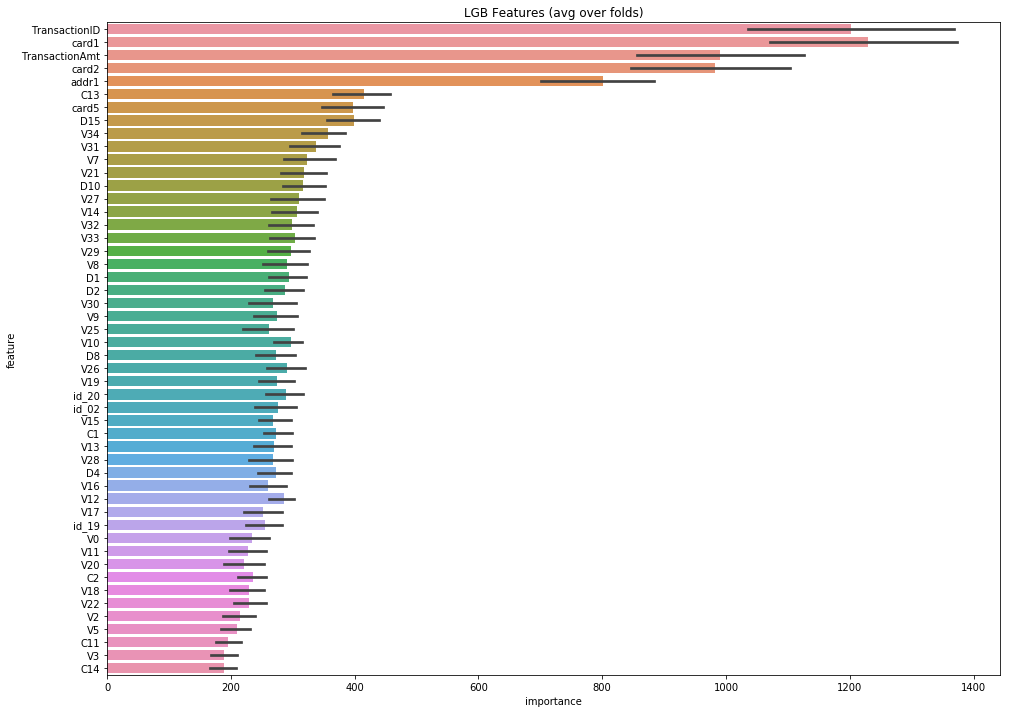

In [103]:
params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          #'categorical_feature': cat_cols
         }
result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='usual', n_jobs=-1)

In [104]:
sub = pd.read_csv('/kaggle/input/ieee-fraud-detection/sample_submission.csv')
sub['isFraud'] = result_dict_lgb['prediction']
sub.to_csv('submission.csv', index=False)
sub.head()

,TransactionID,isFraud
0,3663549,0.001360
1,3663550,0.001661
2,3663551,0.001966
3,3663552,0.004628
4,3663553,0.001779
